In [1]:
# Import Packages and setup
import numpy as np
import scarlet
import sep 
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')

In [2]:
print(scarlet.__version__)
print(np.__version__)
print(sep.__version__)

1.0.1+gfde109a
1.20.1
1.1.1


HSC data:
    
det: List of source positions and footprints detected on a coadd patch. (FITS BINTABLE)

warp: Image of a single visit (CORR) transformed onto a destination tangential plane in a tract. (Multi-extension FITS IMAGE + BINTABLE)

calexp: Coadd image in a single band, or resultant image from the Stack stage, which combines all the overlapped warp images. (Multi-extension FITS IMAGE + BINTABLE)

In [3]:
# Load the HSC image data
obs_hdu = fits.open('../../HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/s16a_udeep/deepCoadd/HSC-G/10054/0,0/calexp-HSC-G-10054-0,0.fits.gz')
obs_hdu

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fff556fab10>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fff55720390>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fff55726590>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fff556fad90>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fff55726990>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fff5572ee50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fff556b3190>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fff556b9810>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fff556bca50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fff556c0c10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fff556c4a10>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fff556c7610>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fff556cb410>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fff556cf210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fff556cfcd0>, <astropy.io.fits.hd

In [4]:
data_hsc = obs_hdu[1].data
wcs_hsc = WCS(obs_hdu[1].header)
channels_hsc = ['g']

print(data_hsc, wcs_hsc)
print(data_hsc.shape[0])

[[ 0.03630908 -0.04750747  0.01221577 ...  0.00250312  0.00250251
   0.0025019 ]
 [ 0.03577255 -0.06356671 -0.01168542 ...  0.00250342  0.00250281
   0.0025022 ]
 [ 0.00729306 -0.00223656  0.01258546 ...  0.00250371  0.0025031
   0.00250249]
 ...
 [ 0.001369    0.00136958  0.00137015 ...  0.00370985  0.00371042
   0.00371099]
 [ 0.00136812  0.00136869  0.00136926 ...  0.00371015  0.00371072
   0.00371129]
 [ 0.00136723  0.0013678   0.00136838 ...  0.00371044  0.00371101
   0.00371158]] WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 148.760330578512  3.71900826446281  
CRPIX : 18000.0  18000.0  
CD1_1 CD1_2  : -4.66666666666667e-05  0.0  
CD2_1 CD2_2  : 0.0  4.66666666666667e-05  
NAXIS : 4100  4100
4100


In [5]:
num=11

print(obs_hdu[num].data)
print(obs_hdu[num].header)

[('cmodel.dev.flux',  11) ('cmodel.dev.flux.err',  12)
 ('cmodel.exp.flux',  13) ('cmodel.exp.flux.err',  14)
 ('cmodel.flux',  15) ('cmodel.flux.err',  16) ('flux.gaussian',  17)
 ('flux.gaussian.err',  18) ('flux.kron',  19) ('flux.kron.err',  20)
 ('flux.psf',  21) ('flux.psf.err',  22) ('cmodel.dev.flux',  27)
 ('cmodel.dev.flux.err',  28) ('cmodel.exp.flux',  29)
 ('cmodel.exp.flux.err',  30) ('cmodel.flux',  31)
 ('cmodel.flux.err',  32) ('flux.gaussian',  33)
 ('flux.gaussian.err',  34) ('flux.kron',  35) ('flux.kron.err',  36)
 ('flux.psf',  37) ('flux.psf.err',  38) ('cmodel.dev.flux',  43)
 ('cmodel.dev.flux.err',  44) ('cmodel.exp.flux',  45)
 ('cmodel.exp.flux.err',  46) ('cmodel.flux',  47)
 ('cmodel.flux.err',  48) ('flux.gaussian',  49)
 ('flux.gaussian.err',  50) ('flux.kron',  51) ('flux.kron.err',  52)
 ('flux.psf',  53) ('flux.psf.err',  54) ('cmodel.dev.flux',  59)
 ('cmodel.dev.flux.err',  60) ('cmodel.exp.flux',  61)
 ('cmodel.exp.flux.err',  62) ('cmodel.flux',  

In [6]:
obs_hdu[11].data[10]

('flux.psf', 21)

In [7]:
# How do I get PSF??

# Show HSC data

In [8]:
print(obs_hdu[1].data.max(), obs_hdu[1].data.min())

178.94392 -0.99015415


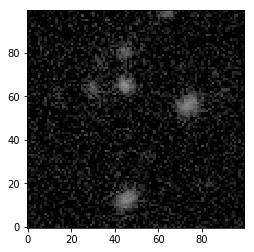

(100, 100, 3)


In [9]:
from scarlet.display import AsinhMapping

stretch = 0.2
Q = 5
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
img_rgb = scarlet.display.img_to_rgb(obs_hdu[1].data, norm=norm) #greyscale image b/c just G filter
img_rgb_cut = img_rgb[0:100, 0:100]
plt.imshow(img_rgb_cut)
plt.show()

print(img_rgb_cut.shape) #channels, height, width

# Show Scarlet display psf

In [10]:
swap_img_rgb_cut = np.swapaxes(img_rgb_cut,0,2)
print(swap_img_rgb_cut.shape) #channels, height, width

(3, 100, 100)


In [11]:
# Model

model_psf = scarlet.GaussianPSF(sigma=(0.8,)*len(channels_hsc))

model_frame = scarlet.Frame(
    swap_img_rgb_cut.shape,
    #wcs=wcs_hsc,
    psf=model_psf,
    channels=['g', 'g1', 'g2']) #two fake channels from greyscale to RGB... will have to fix

In [12]:
# HSC observation frame from data

observation = scarlet.Observation(
    swap_img_rgb_cut,
    #wcs=wcs_hsc,
    psf= scarlet.GaussianPSF(sigma=(0.3,)*len(channels_hsc)),
    weights=None, 
    channels=['g', 'g1', 'g2']).match(model_frame)

In [13]:
# I NEED DETECTION CATALOG FOR "CENTERS" in
# scarlet.display.show_observation(observation, norm=norm, sky_coords=centers, show_psf=True)

# Build detection catalog

In [14]:
# Here is original
"""
def makeCatalog(obs_lr, obs_hr, lvl = 3, wave = True):
    # Create a catalog of detected source by running SEP on the wavelet transform 
    # of the sum of the high resolution images and the low resolution images interpolated to the high resolution grid
    #Interpolate LR to HR
    interp = scarlet.interpolation.interpolate_observation(obs_lr, obs_hr)
    # Normalisation 
    interp = interp/np.sum(interp, axis = (1,2))[:,None, None]
    hr_images = obs_hr.data/np.sum(obs_hr.data, axis = (1,2))[:,None, None]
    # Summation to create a detection image
    detect_image = np.sum(interp, axis = 0) + np.sum(hr_images, axis = 0)
    # Rescaling to HR image flux
    detect_image *= np.sum(obs_hr.data)
    # Wavelet transform
    wave_detect = scarlet.Starlet(detect_image, lvl=lvl, direct = False).coefficients[0]
    
    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
    else:
        detect = detect_image

        # Runs SEP detection
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, 3, err=bkg.globalrms)
    bg_rms = []
    for img in [obs_lr.data, obs_hr.data]:
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
        else:
            bg_rms.append(sep.Background(img).globalrms)
        
    return catalog, bg_rms, detect_image
"""

# my modification

# In ~/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/scarlet-1.0.1+gfde109a-py3.7-linux-ppc64le.egg/scarlet/renderer.py
# change np.int() to int() --> not supported in numpy 1.20.1, depreciation throws error

# In ~/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/scarlet-1.0.1+gfde109a-py3.7-linux-ppc64le.egg/scarlet/wavelet.py
# change np.int() to int() not supported in numpy 1.20.1, depreciation throws error
        
obs_hsc = observation    
    
def makeCatalog(obs_hr, lvl = 3, wave = True):
    hr_images = obs_hr.data/np.sum(obs_hr.data, axis = (1,2))[:,None, None]
    # Summation to create a detection image
    #detect_image = np.sum(interp, axis = 0) + np.sum(hr_images, axis = 0)
    detect_image = np.sum(hr_images, axis = 0)
    # Rescaling to HR image flux
    detect_image *= np.sum(obs_hr.data)
    # Wavelet transform
    wave_detect = scarlet.Starlet(detect_image, direct = False).coefficients[0]
    
    if wave:
        # Creates detection from the first 3 wavelet levels
        detect = wave_detect[:lvl,:,:].sum(axis = 0)
        #print(detect)
    else:
        detect = detect_image
        print(detect)
        
        # Runs SEP detection
    #detect = detect_image
    #print(detect.flags) # C_CONTIGUOUS : False throws ValueError: array is not C-contiguous
    detect = detect_image.copy(order='C')
    
    bkg = sep.Background(detect)
    catalog = sep.extract(detect, 3, err=bkg.globalrms)
    bg_rms = []
    for img in obs_hr.data:
        if np.size(img.shape) == 3:
            bg_rms.append(np.array([sep.Background(band).globalrms for band in img]))
        else:
            bg_rms.append(sep.Background(img.copy(order='C')).globalrms) #same C-order issue
        
    return catalog, bg_rms, detect_image

# Making catalog. 
# With the wavelet option on, only the first 3 wavelet levels are used for detection. Set to 1 for better detection
wave = 1
lvl = 3
catalog_hsc, bg_hsc, detect = makeCatalog(obs_hsc, lvl, wave)

# we can now set the empirical noise rms for both observations
obs_hsc.weights = np.ones(obs_hsc.shape) / (np.array(bg_hsc)**2)[:, None, None]  #make array!

print(len(catalog_hsc))
print(len(detect))

print(catalog_hsc)
print(detect)

print(bg_hsc) # SHOULD NOT BE ALL 1's!
print(obs_hsc.weights)

11
100
[(3.,  384,  268, 73, 92, 29, 55, 80.27659447, 44.21475197,  18.67715932,  36.87754035,   -4.08981436, 1.16541012e-06, 2.10842185e-06, -4.27480387e-07,  6.14445496,  4.21904898, -1.35961032, 0.05487394, 0.02779169,  0.01217132,  93647.25  ,  94032.,  848.8125, 1052.99987793, 81, 44, 81, 44, 1)
 (3.,  296,  209, 54, 76, 35, 54, 65.13736882, 44.68227123,  15.22553966,  14.7360249 ,   -0.73928943, 8.67225988e-07, 8.03835042e-07,  3.02145832e-09,  3.96982813,  3.76855803, -0.62554157, 0.0658395 , 0.06802662,  0.00660618,  95304.375 ,  95013., 1222.875 , 1296.        , 65, 44, 65, 44, 1)
 (3.,  386,  270, 49, 83, 22, 39, 62.99611386, 29.86386681,  53.32579728,  12.58508048,   -4.11975128, 3.30550731e-06, 8.13943920e-07, -4.22735817e-07,  7.33063555,  3.48893404, -0.09977542, 0.01923921, 0.08152083,  0.01259599,  88546.5   ,  89676.,  761.625 , 1008.        , 64, 30, 65, 29, 1)
 (3.,  488,  252, 83, 99, 27, 73, 96.64701153, 61.74096008,  20.45194098, 185.90911219,   22.7052951 , 2.353

/home/paleo2/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


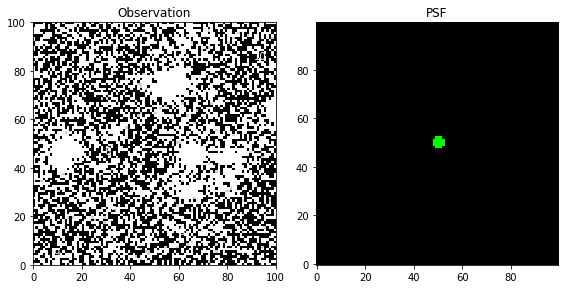

In [15]:
# Create a color mapping for the HSC image
norm_hsc = AsinhMapping(minimum=-1, stretch=5, Q=3)
norms = norm_hsc

# Get the source coordinates from the HST catalog
pixel_hsc = np.stack((catalog_hsc['y'], catalog_hsc['x']), axis=1)
# Convert the HST coordinates to the HSC WCS
ra_dec = obs_hsc.get_sky_coord(pixel_hsc)


# Model

model_psf = scarlet.GaussianPSF(sigma=(0.8,)*len(channels_hsc))

model_frame = scarlet.Frame(
    swap_img_rgb_cut.shape,
    #wcs=wcs_hsc,
    psf=model_psf,
    channels=['g', 'g1', 'g2']) #two fake channels from greyscale to RGB... will have to fix

# Observation Frame w/ Weights! (TODO: fix so all weights isn't 1)

observation = scarlet.Observation(
    swap_img_rgb_cut,
    #wcs=wcs_hsc,
    psf= scarlet.GaussianPSF(sigma=(0.6,)*len(channels_hsc)),
    weights=obs_hsc.weights, 
    channels=['g', 'g1', 'g2']).match(model_frame)

scarlet.display.show_observation(observation, norm=norm, sky_coords=ra_dec, show_psf=True)
plt.show()

In [16]:
centers = ra_dec
centers

array([[44.21475197, 80.27659447],
       [44.68227123, 65.13736882],
       [29.86386681, 62.99611386],
       [61.74096008, 96.64701153],
       [76.32957787, 56.57173181],
       [22.52821322, 32.9393899 ],
       [47.06608483, 30.6413359 ],
       [45.56717465, 11.12622799],
       [14.07275663, 61.16470404],
       [ 5.01733332,  9.69917947],
       [85.92564594, 93.74784275]])

In [17]:
sources, skipped = scarlet.initialization.init_all_sources(model_frame, 
                                                           centers, 
                                                           observation, 
                                                           max_components=2, 
                                                           min_snr=50,
                                                           thresh=1,
                                                           fallback=True,
                                                           silent=True,
                                                           set_spectra=True
                                                          )

for k, src in enumerate(sources):
    print (f"{k}: {src.__class__.__name__}")

Failed to initialize source 0
Failed to initialize source 1
Failed to initialize source 2
Failed to initialize source 3
Failed to initialize source 4
Failed to initialize source 5
Failed to initialize source 6
Failed to initialize source 7
Failed to initialize source 8
Failed to initialize source 9
Failed to initialize source 10


IndexError: too many indices for array: array is 1-dimensional, but 4 were indexed

# Create and Fit Model

In [ ]:
#blend = scarlet.Blend(sources, observation)
#%time it, logL = blend.fit(100, e_rel=1e-4)
#print(f"scarlet ran for {it} iterations to logL = {logL}")
#scarlet.display.show_likelihood(blend)
#plt.show()